# Setup

In [1]:
from modules.utils import *
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from tabulate import tabulate
import random

2023-05-27 12:04:25.860243: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Note**
Model is trained using Google Colabs free GPUs. This notebook is therefore for evaluating the model

# Model Evaluation

In [2]:
# Loading model
model = tf.keras.models.load_model(f'{MODEL_PATH}/ShallowNeuralNetwork')


2023-05-27 12:04:28.241768: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-27 12:04:28.241821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: AMD Radeon Pro 5300M

systemMemory: 32.00 GB
maxCacheSize: 1.99 GB



In [55]:
df = load_dataset('sentiment140')

# Create subset based on new data
test_set = df['train'].to_pandas().groupby('sentiment').apply(
    lambda x: x[-1000:]).reset_index(drop=True).replace(4, 1).sample(frac=1)

sentences = SentimentDataset(test_set.text.to_list(), subset='test').process_data()
vectorized = w2v(sentences, return_vector=True).vector

target = test_set.sentiment.to_list()

In [48]:
# Load data
data = SentimentDataset() 

# Apply Word2Vec
w2v(data) 

print('Splitting')
_, X_test, _, y_test = train_test_split(data.vector, data.target, test_size=0.1)


Loading data...


Found cached dataset sentiment140 (/Users/krebs/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)



Loading processed dataset from cache...
Dataset loaded
Applying Word2Vec embedding
Loading Word2Vec model from directory
Vectorizing range(0, 200000) tweets
Word2Vec embedding applied
Splitting


In [49]:
# manual_test = ["My girlfriend and i wen't to the movies during the weekend, it was so nice",
#                "I was just laid off my work... Why is this life right now",
#                "Have you read this new article about Transformers, it is super fascinating",
#                "Messi is the best football player ever, you can not convince me otherwise",
#                "I just got my computer stolen, why are some people so mean?"]
# 
# target = [1, 0, 1, 1, 0]
# processed = SentimentDataset(manual_test, subset='test').process_data()
# processed_vector = data.w2v_vectorize(processed)

Processing
Processing test input


In [51]:
# test predictions
prediction = model.predict(X_test)


# Fabricated tweet predictions
prediction_2 = model.predict(vectorized)


63/63 [==============================] - 1s 9ms/step


In [ ]:
prediction = np.where(prediction > 0.5, 1, 0) # Transforming probability output to predicted class
prediction = [pred[0] for pred in prediction] # Unnesting results

prediction_2 = np.where(prediction_2 > 0.5, 1, 0)
prediction_2 = [pred[0] for pred in prediction_2]


In [56]:
print('Test set accuracy:', accuracy_score(y_test, prediction))
print('Unseen data prediction:', accuracy_score(target, prediction_2))

Test set accuracy: 0.7337
Unseen data prediction: 0.7525


In [57]:
print(classification_report(y_test, prediction))


              precision    recall  f1-score   support

           0       0.74      0.72      0.73     10066
           1       0.72      0.75      0.74      9934

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000



In [58]:
confusion_matrix(y_test, prediction)


array([[7215, 2851],
       [2475, 7459]])

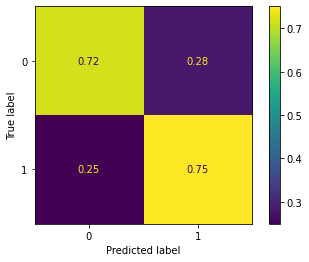

In [59]:
ConfusionMatrixDisplay(confusion_matrix(y_test, prediction, normalize='true')).plot()
plt.show()


## Exploring Errors

In [133]:
# Indices of wrong predictions
wrong_predictions = [i for i, (a,b) in enumerate(zip(prediction_2, target)) if a != b]

# Random list of 5 index positions
indexes = [wrong_predictions[random.randint(0, len(wrong_predictions)-1)] for _ in range(5)]

# Original tweet
original = test_set.text.to_list()

# Processed tweet 
processed = sentences

In [134]:
# Dict comprehension for
texts = {original[i]:processed[i] for i in wrong_predictions}
labels = {target[i]:prediction_2[i] for i in wrong_predictions}

In [135]:
# Table for tabulate
table = [[original[i], processed[i], target[i], prediction_2[i]] for i in indexes]

In [137]:
print(tabulate(table, headers=["Original Tweet","Processed Tweet", "True Label", "Predicted Label"]))

Original Tweet                                                                                                               Processed Tweet                                                    True Label    Predicted Label
---------------------------------------------------------------------------------------------------------------------------  ---------------------------------------------------------------  ------------  -----------------
@caitykauffman lee's mom is making me go with her tonight bc she doesnt want to sit by herself. p.s. MY BLACKBERRY CAME IN!  lee mom making go tonight bc doesnt want sit p blackberry came              1                  0
Wow... Rest in peace Farrah Fawcett                                                                                          wow rest peace farrah fawcett                                               0                  1
@rhiannonrevolts Yeah I see that.   The last word I'd heard on her did not sound good. Wishing her family good t